Loss (mse): 0.003982259426265955


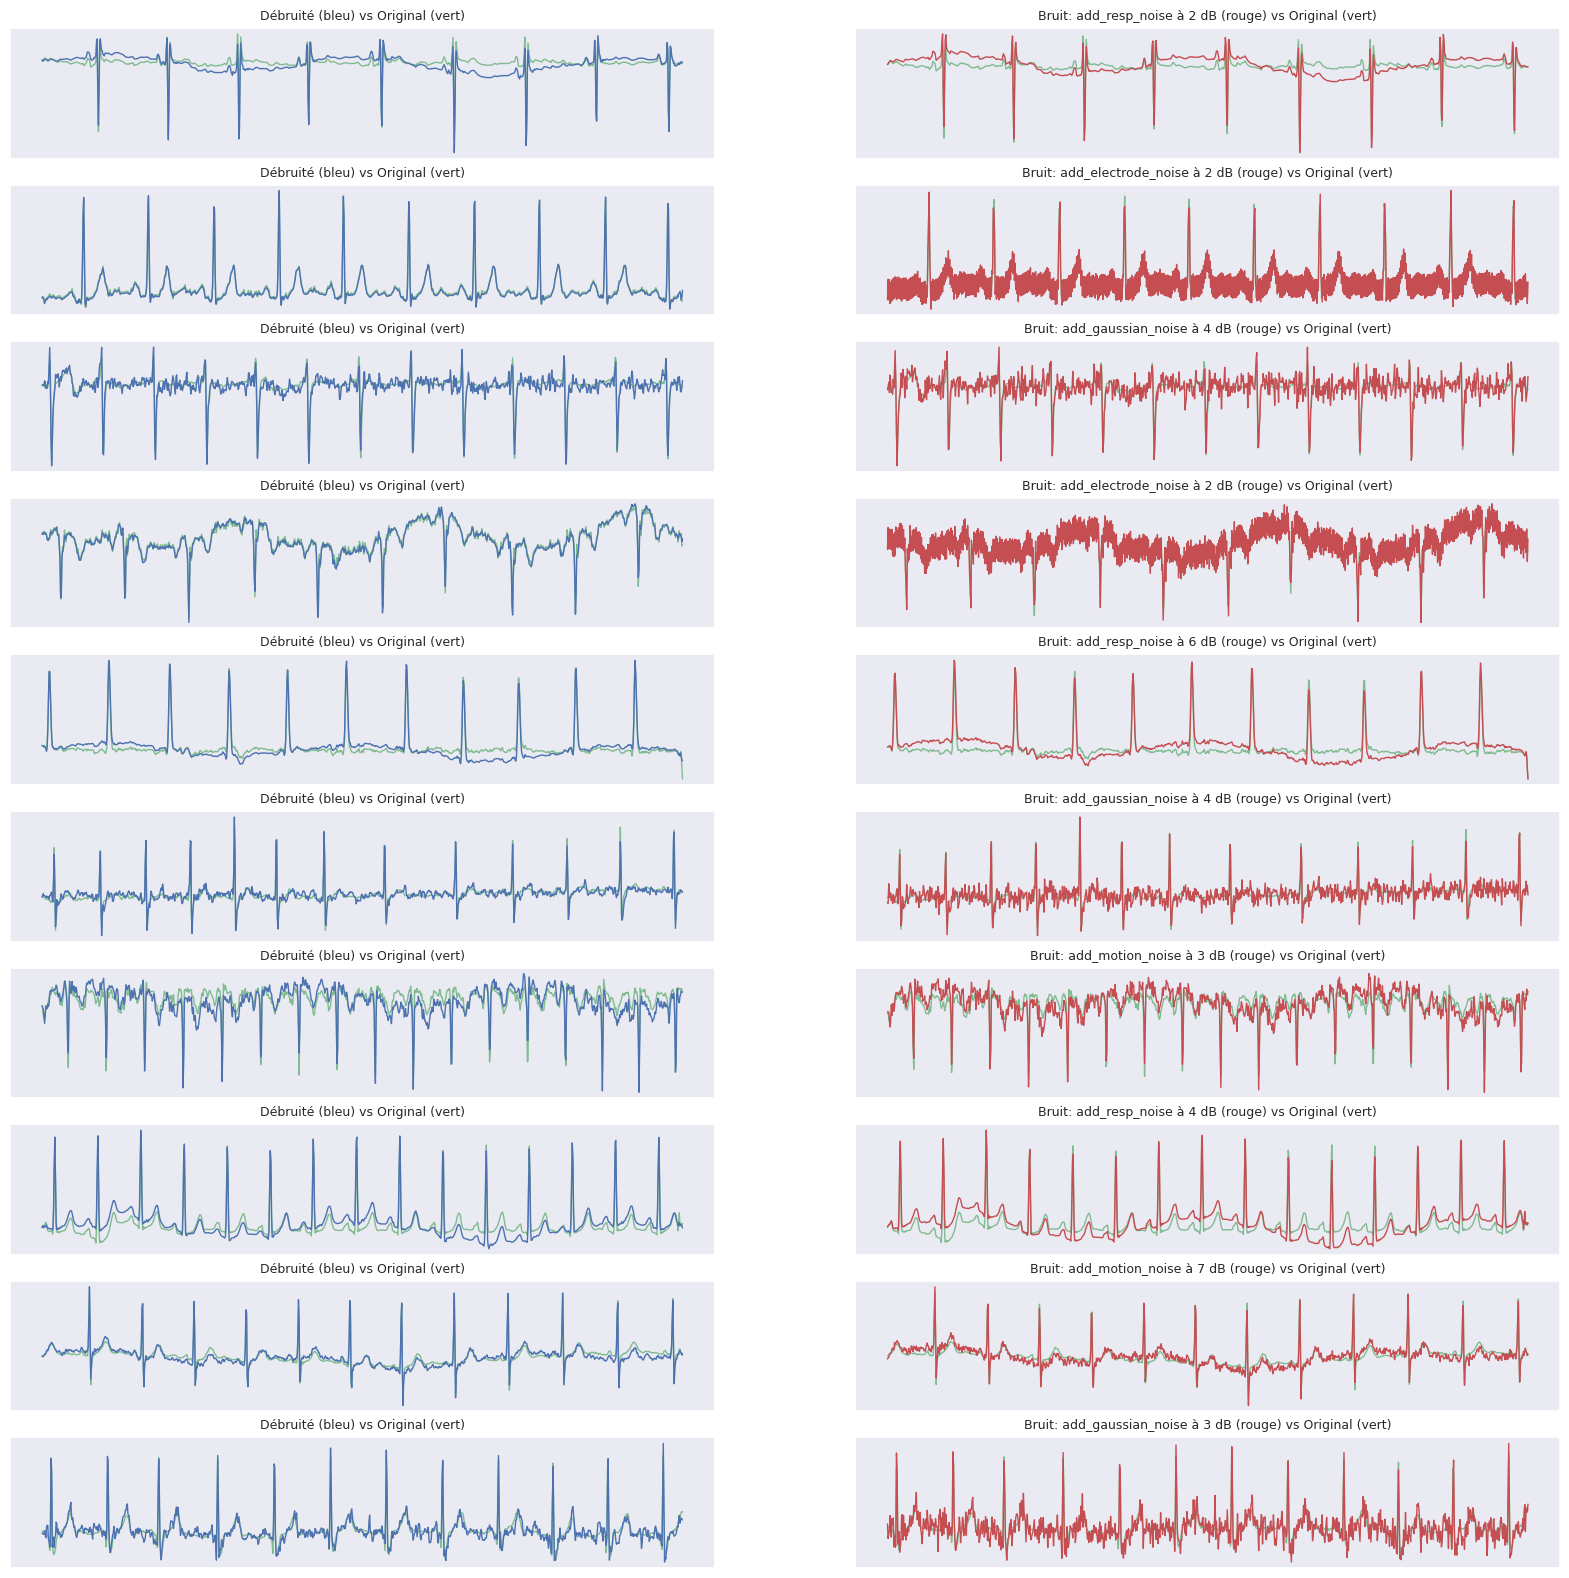

Visualisation sauvegardée sous denoising_comparison.png


In [1]:
import os 
import numpy as np
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from collections import defaultdict
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.signal import sawtooth
import torch.nn.functional as F

sns.set()
seed = 123
np.random.seed(seed)
random.seed(seed)

data_dir = "/kaggle/input/ecg-parse-data"

xtest_path = os.path.join(data_dir, 'X_test.npy')
ytest_path = os.path.join(data_dir, 'Y_test.npy')

X_test = np.load(xtest_path)
Y_test = np.load(ytest_path)

model_dir = "/kaggle/input/ecg-train/best_model.pth"

class ECG_Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float).unsqueeze(0), torch.tensor(self.Y[index], dtype=torch.float).unsqueeze(0)
        
    def __len__(self):
        return len(self.X)

class ECG_Autoencoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dropout):
        super().__init__()
        
        self.conv_encoder = nn.Sequential(
            nn.Conv1d(1, d_model//2, kernel_size=15, padding=7),
            nn.BatchNorm1d(d_model//2),
            nn.GELU(),
            nn.Conv1d(d_model//2, d_model, kernel_size=5, padding=2),
            nn.BatchNorm1d(d_model),
            nn.GELU(),
        )
        
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=d_model,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        self.decoder = nn.Sequential(
            nn.Conv1d(d_model, d_model//2, kernel_size=5, padding=2),
            nn.BatchNorm1d(d_model//2),
            nn.GELU(),
            nn.Conv1d(d_model//2, 1, kernel_size=15, padding=7)
        )

    def forward(self, x):
        # x: [B, 1, 1000]
        x = self.conv_encoder(x)  # [B, d_model, 1000]
        
        # Transformer
        x = x.permute(0, 2, 1)  # [B, 1000, d_model]
        x = self.transformer(x)
        x = x.permute(0, 2, 1)  # [B, d_model, 1000]
        
        return self.decoder(x)

def add_gaussian_noise(signal, snr_db):
    Ps = np.mean(signal**2)
    Pb = Ps / 10**(snr_db / 10)
    noise = np.random.normal(0, np.sqrt(Pb), signal.shape)
    return signal + noise
    
def add_motion_noise(signal, snr_db, fs=100):
    t = np.arange(0, len(signal))/fs
    Ps = np.mean(signal**2)
    P_target = Ps / 10**(snr_db / 10)
    noise = 0.5*np.sin(2*np.pi*0.3 * t) + 0.2*np.random.randn(len(signal))
    Pb = np.mean(noise**2)
    scale = np.sqrt(P_target/Pb)
    noise = noise * scale
    return signal + noise

def add_resp_noise(signal, snr_db, fs=100):
    t = np.arange(0, len(signal))/fs
    Ps = np.mean(signal**2)
    P_target = Ps / 10**(snr_db / 10)
    noise = 0.2*(np.sin(2*np.pi*0.25 * t) + 0.3*np.sin(2*np.pi*0.1 * t))
    Pb = np.mean(noise**2)
    scale = np.sqrt(P_target/Pb)
    noise = noise * scale
    return signal + noise

def add_electrode_noise(signal, snr_db, fs=100):
    t = np.arange(0, len(signal))/fs
    Ps = np.mean(signal**2)
    P_target = Ps / 10**(snr_db / 10)
    noise = 0.3*sawtooth(2*np.pi*50 * t, width=0.5)
    Pb = np.mean(noise**2)
    scale = np.sqrt(P_target/Pb)
    noise = noise * scale
    return signal + noise

def apply_random_noise(signal, snr_db):
    noise_funcs = [
        add_gaussian_noise,
        add_motion_noise,
        add_resp_noise,
        add_electrode_noise
    ]
    noise_func = random.choice(noise_funcs)
    return noise_func(signal, snr_db), noise_func.__name__

def visualize_denoising(model, test_loader, device, n_examples=10, save_path="denoising_comparison.png"):
    model.eval()
    L = []
    with torch.no_grad():
        all_indices = np.random.choice(len(test_loader.dataset), n_examples, replace=False)
        
        plt.figure(figsize=(20, 20))
        
        for i, idx in enumerate(all_indices):
            snr_db = random.randint(2, 7)
            
            _, clean_ecg = test_loader.dataset[idx]
            noisy_ecg, noise_name = apply_random_noise(clean_ecg.numpy().squeeze(), snr_db)
            noisy_ecg = torch.tensor(noisy_ecg, dtype=torch.float)
            noisy_ecg = noisy_ecg.unsqueeze(0).unsqueeze(0).to(device)
            with autocast(device_type='cuda' if 'cuda' in str(device) else 'cpu'):
                denoised_ecg = model(noisy_ecg).cpu()
                loss = F.mse_loss(denoised_ecg, clean_ecg.unsqueeze(0))
            L.append(loss)
            noisy_ecg = noisy_ecg.cpu().numpy().squeeze()
            clean_ecg = clean_ecg.numpy().squeeze()
            denoised_ecg = denoised_ecg.numpy().squeeze()
            
            plt.subplot(n_examples, 2, 2*i + 1)
            plt.plot(clean_ecg, 'g-', alpha=0.7, linewidth=1, label='Original')
            plt.plot(denoised_ecg, 'b-', linewidth=1, label='Débruité')
            plt.title("Débruité (bleu) vs Original (vert)", fontsize=9)
            plt.xticks([])
            plt.yticks([])

            plt.subplot(n_examples, 2, 2*i + 2)
            plt.plot(clean_ecg, 'g-', alpha=0.7, linewidth=1, label='Original')
            plt.plot(noisy_ecg, 'r-', linewidth=1)
            plt.title(f"Bruit: {noise_name} à {snr_db} dB (rouge) vs Original (vert)", fontsize=9)
            plt.xticks([])
            plt.yticks([])

        print(f'Loss (mse): {np.mean(L)}')
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.show()
        print(f"Visualisation sauvegardée sous {save_path}")

if __name__ == "__main__":
    test_ds = ECG_Dataset(X_test, Y_test)
    test_loader = DataLoader(test_ds, num_workers=4, pin_memory=True, batch_size=32, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    d_model, n_head, n_layer, dropout = 96, 2, 2, 0.05
    model = ECG_Autoencoder(d_model, n_head, n_layer, dropout)
    model.load_state_dict(torch.load(model_dir, weights_only=True))
    model.to(device)

    scaler = GradScaler()
    visualize_denoising(model, test_loader, device)